In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

**before proceeding lets get to know about our dataset**

PassengerId is the unique id of the row and it doesn't have any effect on target:

Survived is the target variable we are trying to predict (0 or 1):

    1 = Survived
    0 = Not Survived
Pclass (Passenger Class) is the socio-economic status of the passenger and it is a categorical ordinal feature which has 3 unique values (1, 2 *or *3):

    1 = Upper Class
    2 = Middle Class
    3 = Lower Class
Name, Sex and Age are self-explanatory

SibSp is the total number of the passengers' siblings and spouse

Parch is the total number of the passengers' parents and children

Ticket is the ticket number of the passenger

Fare is the passenger fare

Cabin is the cabin number of the passenger

Embarked is port of embarkation and it is a categorical feature which has 3 unique values (C, Q or S):

    C = Cherbourg
    Q = Queenstown
    S = Southampton

In [2]:
# df.head()

In [3]:
df_train=pd.read_csv("train.csv")
df_test=pd.read_csv("test_titinic.csv")
df=df_train.append(df_test,sort=False)

C:\Users\ASUS\AppData\Local\Temp\ipykernel_16032\2481695462.py:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df=df_train.append(df_test,sort=False)


In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


In [32]:
print("missing values in df_train:\n ")            

for feature in df_train.columns:
        if df_train[feature].isnull().sum()>0:
            print(feature)
print("missing values in df_test:\n ")            
for feature in df_test.columns:
        if df_test[feature].isnull().sum()>0:
            print(feature)
        
        

missing values in df_train:
 
Age
Cabin
Embarked
missing values in df_test:
 
Age
Fare
Cabin


### Findings from the info:

Object type:

    Name, Sex, Cabin, Embarked are object type, they're most likey to be strings.
    PassengerId, Pclass, SibSp, Parch are integers.
    Age and Fare are floating point numbers.

Missing Values are found in both training and testing set:

In training set `Age, Cabin, Embarked` contain missing values.

In testing set `Age, Fare, Cabin` contain missing values

Cabin column has more than 80% of values missing, which may lead to difficulty imputing them

In [33]:
df_train.isnull().sum()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [34]:
df_test.isnull().sum()


PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

## Backgroud Knowledge  

Domain knowledge is crucial for any type of data science problem, though we might no have been a Titanic expert, we have Google. A little bit of background research tells us: 

- Around 2200 were on board, approximately 215 of 900 crew members survived, and 500 out out of 1300 passengers survived. About 38% passengers survived, this number may help us evaluate our model.
- The iceberg strucked the front of Titanic, water entered the ship from the front of the ship and eventually the ship broke in half. 
- According to Wikipedia: *'The thoroughness of the muster was heavily dependent on the class of the passengers; the first-class stewards were in charge of only a few cabins, while those responsible for the second- and third-class passengers had to manage large numbers of people.'*  
- There was a 'women and children first' order to the crew members, which was misunderstood as 'women and children only' by the Second Officer. This may thinner the chance of survival for male passengers. 
- Immigrants(mostly 3rd-class passengers) were blocked from 1st and 2nd-class area bt the U.S. immigration law at that time. They need to travel more distance to the lifeboat deck.  

From these facts, **Pclass, Age and Sex** seem to be the most important features determining survival or not.

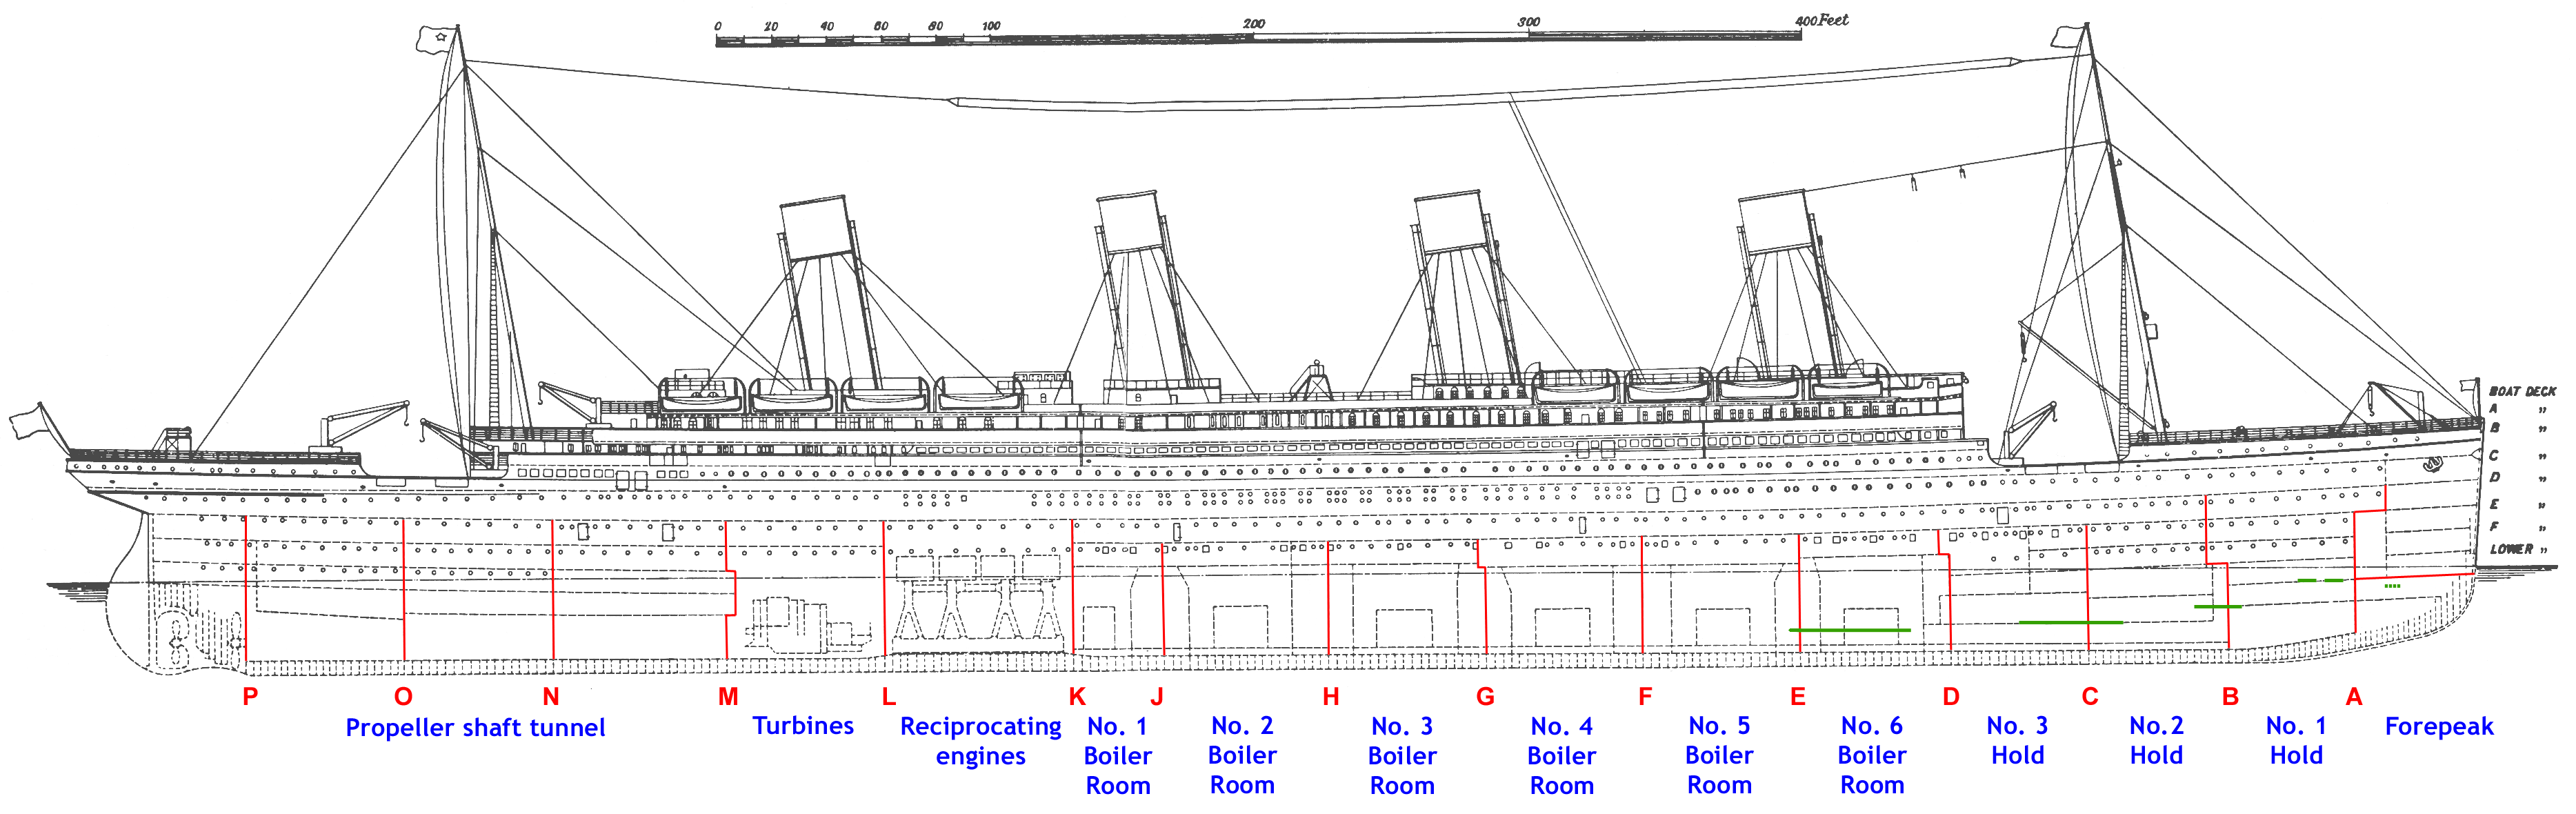

In [35]:
from IPython.display import Image
Image("titnic.png")


In [36]:
# deisplaying all the unique values in each column
df.nunique() 

PassengerId    1309
Survived          2
Pclass            3
Name           1307
Sex               2
Age              98
SibSp             7
Parch             8
Ticket          929
Fare            281
Cabin             9
Embarked          3
prefix           18
dtype: int64

#### Summary: 


- There are duplicates in Name, which may implies there're duplicate records for one person, we'll check that later.
- Duplicates in Ticket implies there are people in groups who boarded with one ticket. Further investigation tells us the Fare is cumulative for group tickets, we may need to split the fare for those.  
- There are 186 distinct values for Cabin, which is much larger than the actual number of Cabin on Titanic, we'll handle that right after.  


#### Cabin

In [37]:
df.Cabin.value_counts().head()

M    1014
C      94
B      65
D      46
E      41
Name: Cabin, dtype: int64

The value of Cabin is formed as Cabin + berth or suite number. The effect of berth/suite number on the chance of survuval is nearly impossible to find out. For simplicity we'll focus on Cabin and discard berth/suite number.



### Ticket

In [38]:
df.loc[(df.Parch == 0) & (df.SibSp == 0), 'Ticket'].value_counts().head(50)

1601               8
S.O.C. 14879       4
PC 17760           4
LINE               4
C 4001             3
PC 17757           3
239853             3
110152             3
358585             2
364498             2
113798             2
24160              2
54636              2
7534               2
PC 17483           2
364516             2
113059             2
C.A. 33595         2
113796             2
2627               2
250655             2
244358             2
PC 17585           2
112058             2
PC 17755           2
S.O./P.P. 3        2
110465             2
PC 17593           2
113572             2
12749              2
16966              2
28403              2
13050              2
F.C.C. 13534       2
113781             2
11813              2
239865             2
C.A. 6212          2
PC 17477           2
113503             2
F.C.C. 13528       2
250647             2
17463              2
PC 17608           2
2699               2
36568              2
315090             1
SOTON/OQ 3920

Beside families travelling together, there are many group of passengers boarded with one ticket. This may lead to difficulty calculating split fare for each members if people in one group is separated in training and testing set.  
  
More details about this would be addressed in feature engineering section. 


## Spotting Data Inconsistency

**Name**

Earlier we saw there're passengers who share same name, let's examine are those duplicate entries or not.

In [39]:
df.Name.value_counts()[df.Name.value_counts() > 1]


Connolly, Miss. Kate    2
Kelly, Mr. James        2
Name: Name, dtype: int64

In [40]:
df.loc[(df.Name == 'Connolly, Miss. Kate') | (df.Name == 'Kelly, Mr. James'),:].sort_values('Name')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix
289,290,1.0,3,"Connolly, Miss. Kate",female,22.0,0,0,370373,7.7500,M,Q,", Miss."
6,898,NaN,3,"Connolly, Miss. Kate",female,30.0,0,0,330972,7.6292,M,Q,", Miss."
696,697,0.0,3,"Kelly, Mr. James",male,44.0,0,0,363592,8.0500,M,S,", Mr."
0,892,NaN,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,M,Q,", Mr."


The Titanic Encyclopedia tells us there were indeed two Kate Connolly(one should be Catherine), who boarded Titanic as a third class passenger, however the age of the one holding Ticket 330972 is shown to be 41 on the Encyclopedia, not sure which record is correct so I'll leave it at 30.

There were also two Kelly James who boarded as a third class passenger, though the ages on the website do not align with the result too.



**Prefix and Sex**

In [41]:
# extract prefix from Name
df['prefix'] = df.Name.str.extract(r'(\, .*?\.)')
df['prefix'] = df.prefix.str.replace('\, ', '')

fem_prefix = ['Miss.', 'Mrs.', 'Mme.', 'Mlle.']
male_prefix = ['Mr.', 'Mister.', 'Master.']

inconsistent_index = []

# Iterate over each row in the dataframe
for i, val in df.iterrows():
    # Check if the prefix is a female prefix
    if val['prefix'] in fem_prefix:
        # If the prefix is a female prefix, check if the Sex is 'Male'
        if val['Sex'] == 'Male':
            # If there is an inconsistency between the prefix and Sex, add the row index to the list
            inconsistent_index.append(i)
    # Check if the prefix is a male prefix
    elif val['prefix'] in male_prefix:
        # If the prefix is a male prefix, check if the Sex is 'Female'
        if val['Sex'] == 'Female':
            # If there is an inconsistency between the prefix and Sex, add the row index to the list
            inconsistent_index.append(i)

# Print the number of rows where there is an inconsistency between the prefix and Sex
print('Number of Prefix and Sex inconsistencies: {}'.format(len(inconsistent_index)))


Number of Prefix and Sex inconsistencies: 0


C:\Users\ASUS\AppData\Local\Temp\ipykernel_16032\1204783416.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df['prefix'] = df.prefix.str.replace('\, ', '')


**Parch Size**

Accroding to the definition given by Kaggle, Parch is the total number of parents + children on board, it's fair to assume that for passenger under age of 17, this number should always be less than 2.

In [42]:
df[(df.Parch > 2) & (df.Age <= 17)]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix


There is only one such passenger, a little research on the Encyclopedia shows there were 4 Fords travelling together:

Miss Dollina Margaret Ford (Sister)
Mr Edward Watson Ford (Brother)
Miss Robina Maggie Ford (Sister)
Mrs Margaret Ann Watson Ford (Mother)
So it appears that the values of SibSp and Parch is swapped, let's correct that.

In [43]:
df.loc[(df.Parch > 2) & (df.Age <= 17), ['SibSp', 'Parch']] = [3, 1]


In [44]:
Fords = ['Ford, Mr. William Neal', 'Ford, Miss. Robina Maggie "Ruby"', 'Ford, Miss. Doolina Margaret "Daisy"', 'Ford, Mrs. Edward (Margaret Ann Watson)', 'Ford, Mr. Edward Watson']

df.loc[df.Name.isin(Fords)]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix
86,87,0.0,3,"Ford, Mr. William Neal",male,16.0,3,1,W./C. 6608,34.375,M,S,Mr.
147,148,0.0,3,"Ford, Miss. Robina Maggie ""Ruby""",female,9.0,3,1,W./C. 6608,34.375,M,S,Miss.
436,437,0.0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,3,1,W./C. 6608,34.375,M,S,Miss.
736,737,0.0,3,"Ford, Mrs. Edward (Margaret Ann Watson)",female,48.0,1,3,W./C. 6608,34.375,M,S,Mrs.
167,1059,NaN,3,"Ford, Mr. Edward Watson",male,18.0,3,1,W./C. 6608,34.375,M,S,Mr.


Turns out the numbers are all wrong for siblings of William, let's correct them.
Be noted that Mrs Margaret Ann Watson Ford is actually travelling with a sibling Elizabeth Johnston.

In [45]:
sibs = ['Ford, Miss. Robina Maggie "Ruby"', 'Ford, Miss. Doolina Margaret "Daisy"', 'Ford, Mr. Edward Watson']

df.loc[df.Name.isin(sibs), ['SibSp', 'Parch']] = [3, 1]

## Identifying Outliers

**Age**

In [46]:
df.Age.describe().reset_index()

,index,Age
0,count,1046.000000
1,mean,29.881138
2,std,14.413493
3,min,0.170000
4,25%,21.000000
5,50%,28.000000
6,75%,39.000000
7,max,80.000000


Age look's fine

**family Size**

In [81]:
df['FamilySize'] = df.Parch + df.SibSp

**Fare**

In [47]:
df.Fare.describe()

count    1308.000000
mean       33.295479
std        51.758668
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64

It's strange as the fare price from some of the passengers is 0. We'll investigate this.



In [48]:
df[df.Fare == 0]


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,prefix
179,180,0.0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,M,S,Mr.
263,264,0.0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B,S,Mr.
271,272,1.0,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,M,S,Mr.
277,278,0.0,2,"Parkes, Mr. Francis ""Frank""",male,NaN,0,0,239853,0.0,M,S,Mr.
302,303,0.0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,M,S,Mr.
413,414,0.0,2,"Cunningham, Mr. Alfred Fleming",male,NaN,0,0,239853,0.0,M,S,Mr.
466,467,0.0,2,"Campbell, Mr. William",male,NaN,0,0,239853,0.0,M,S,Mr.
481,482,0.0,2,"Frost, Mr. Anthony Wood ""Archie""",male,NaN,0,0,239854,0.0,M,S,Mr.
597,598,0.0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,M,S,Mr.
633,634,0.0,1,"Parr, Mr. William Henry Marsh",male,NaN,0,0,112052,0.0,M,S,Mr.


Noticed that these passengers with Fare = 0 all embarked at Southampton, which is where Titanic set sail. A little a Googling tells us:

Some of them are Titanic workers
Some of them are the people who runs the company of Titinic and their relatives, for example Joseph Bruce Ismay is the chairman of the company.

So it's safe to assume these 0s are legit, they are people who actually got a free ride. However, the survival rate of crew members is likely to be significant different than passengers, so we can consider leaving these people out of our model.



In [65]:
df['logFare'] = np.log10(df.Fare + 1)

In [49]:
df[['Survived', 'Pclass', 'Name', 'Fare', 'Cabin', 'Ticket']].sort_values('Fare', ascending = False).head(10)


,Survived,Pclass,Name,Fare,Cabin,Ticket
258,1.0,1,"Ward, Miss. Anna",512.3292,M,PC 17755
679,1.0,1,"Cardeza, Mr. Thomas Drake Martinez",512.3292,B,PC 17755
343,NaN,1,"Cardeza, Mrs. James Warburton Martinez (Charlo...",512.3292,B,PC 17755
737,1.0,1,"Lesurer, Mr. Gustave J",512.3292,B,PC 17755
341,1.0,1,"Fortune, Miss. Alice Elizabeth",263.0000,C,19950
53,NaN,1,"Fortune, Miss. Ethel Flora",263.0000,C,19950
27,0.0,1,"Fortune, Mr. Charles Alexander",263.0000,C,19950
88,1.0,1,"Fortune, Miss. Mabel Helen",263.0000,C,19950
438,0.0,1,"Fortune, Mr. Mark",263.0000,C,19950
69,NaN,1,"Fortune, Mrs. Mark (Mary McDougald)",263.0000,C,19950


Sorted by fare price, we see the top 4 values of fare belongs to 4 groups of 1st-class passengers, therefore the high price makes sense.



## Survival Rate in Training Set

Survival rate in training set: 0.38


d:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Survived', ylabel='count'>

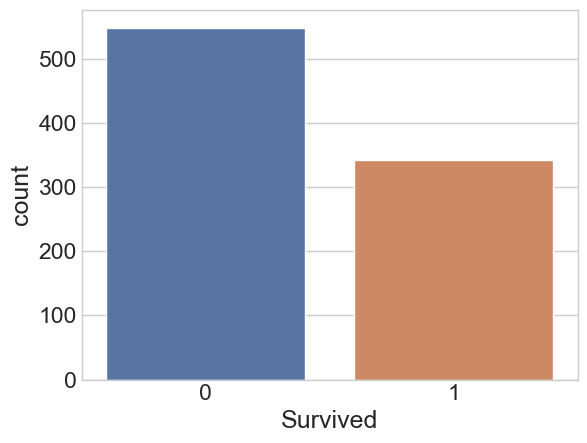

In [55]:
print('Survival rate in training set: {}'.format(round(df_train.Survived.mean(), 2)))
sns.set(font_scale=1.5)
plt.style.use('seaborn-whitegrid')
sns.countplot(df_train.Survived)

#  A Closer Look at Each Variable and How They Affect Survival`

### Important Note about Cabin

- Missing vlaues in Cabin were replace by 'M' 
- One first class passenger was in Cabin 'T', not sure what it means. Since the information I gathered on the Internet shows no presence of Cabin T, that value was replaced by C cause C has the most people from class 1

In [75]:
# 'M' represents missing
df.Cabin = df.Cabin.apply(lambda row: row[0] if pd.notnull(row) else 'M')

# T only consists of 1 passenger and is from class1
# replace cabin T with C cause C has the most people from class 1
df.loc[df.Cabin == 'T', 'Cabin'] = 'C'

- **Fare** and **logFare** both have positive correlaiton with Survivied, but **logFare** is higher, which may imply that **logFare** is a better predictor than **Fare**


### Frequency of Values in Each Variable

d:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Users\ASUS\anaconda3\lib\site-p

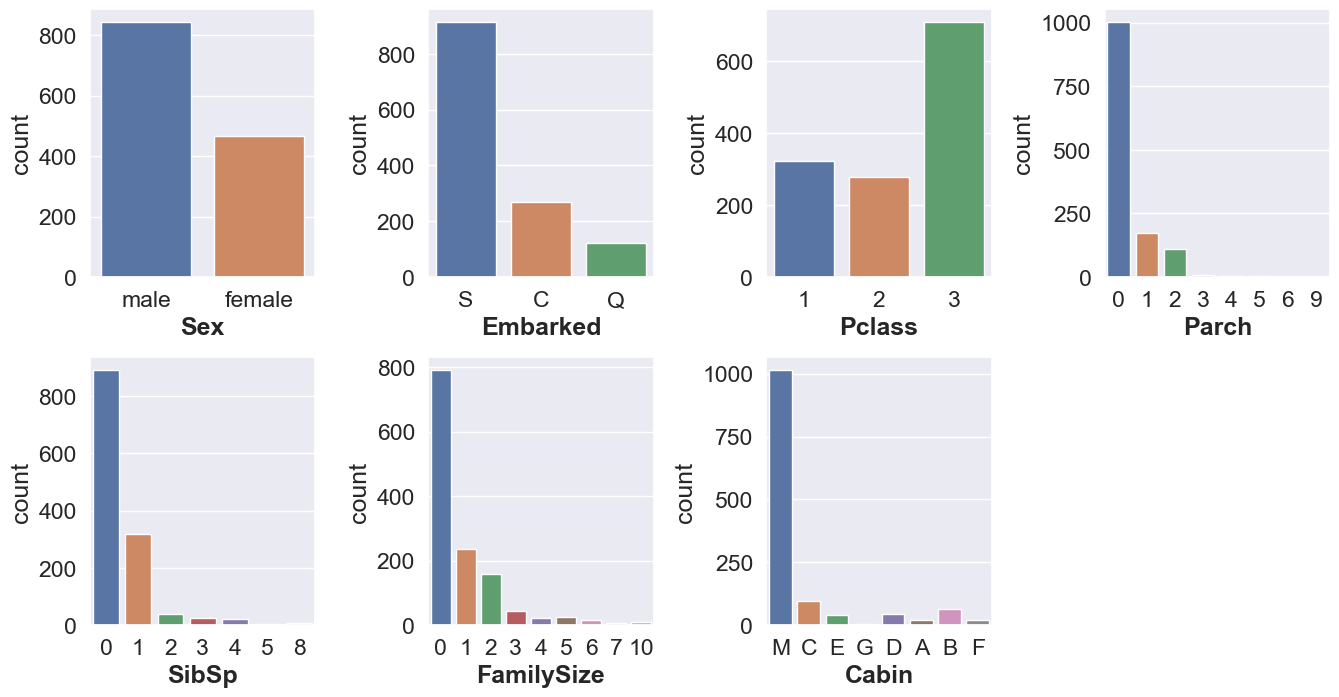

In [77]:
import math
cate_variables = ['Sex', 'Embarked', 'Pclass', 'Parch', 'SibSp', 'FamilySize', 'Cabin']

def cate_countplot(data, var_list, cols=4, width=16, height=8, hspace=0.3, wspace=0.5):
    plt.style.use('seaborn-whitegrid')
    sns.set(font_scale=1.5)
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(len(var_list) / cols)
    
    for i, var in enumerate(var_list):
        ax = fig.add_subplot(rows, cols, i+1)
        sns.countplot(var, data=data)
        plt.xlabel(var, weight='bold')
        
cate_countplot(data=df, var_list=cate_variables)

### How Each Variable Affects Survival

d:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Users\ASUS\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
d:\Users\ASUS\anaconda3\l

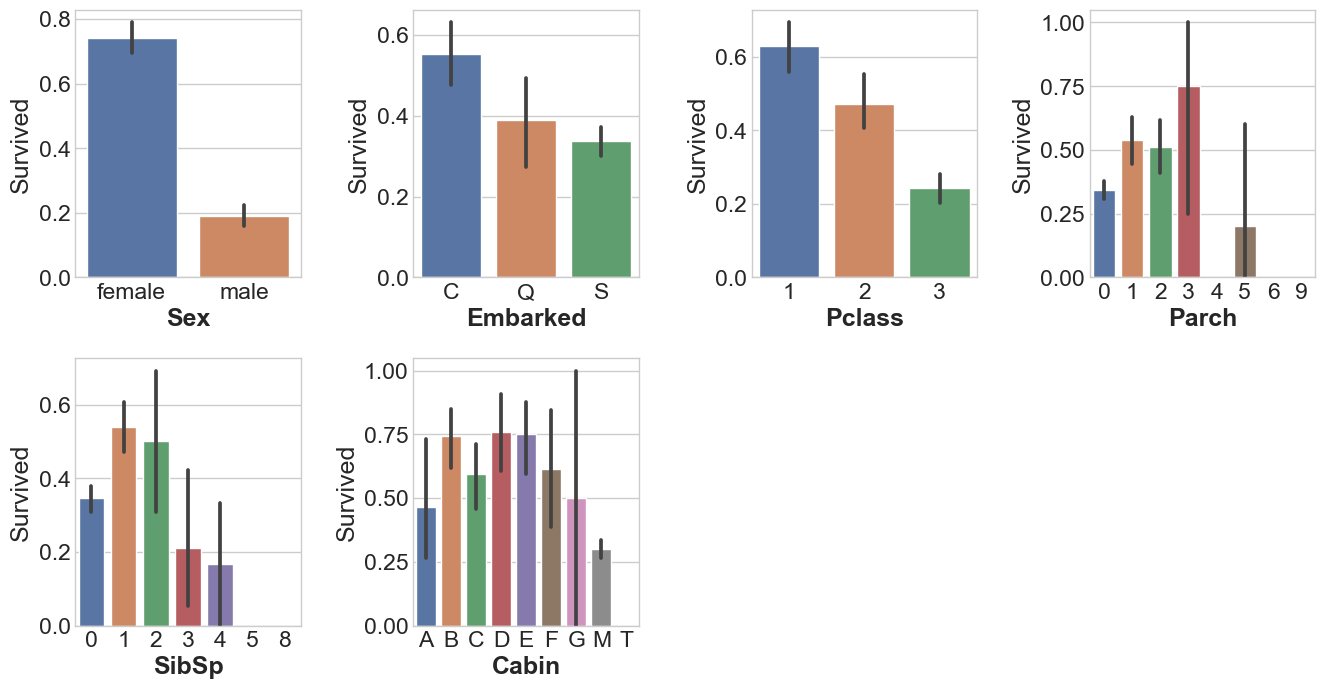

In [73]:
def create_bars(data, variables, cols=4, width=16, height=8, hspace=0.3, wspace=0.5):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=wspace, hspace=hspace)
    rows = math.ceil(len(variables) / cols)

    for i, column in enumerate(data[variables].columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.barplot(column,'Survived', data=data.sort_values(column))
        plt.xticks(rotation=0)
        plt.xlabel(column, weight='bold')

create_bars(df, cate_variables)

Summary:
- **Sex**: Female yielded higher chance to survive than male  
- **Pclass**: Not surprisingly, passengers in higher class were more likely to survive  
- **FamilySize**: Survival rate rises with FamilySize at 0 to 3, it encounters a sharp drop at FamilySize = 4 and continues to drop at FamilySize = 5, which too us by surprise  
- **Cabin**: Passengers missing Cabin information have lower chance to survive in general
- **Cabin**: Less than 50% of passengers in Cabin A, G survivied, while passengers in Cabin B, D, E have roughly the same survival rate

d:\Users\ASUS\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


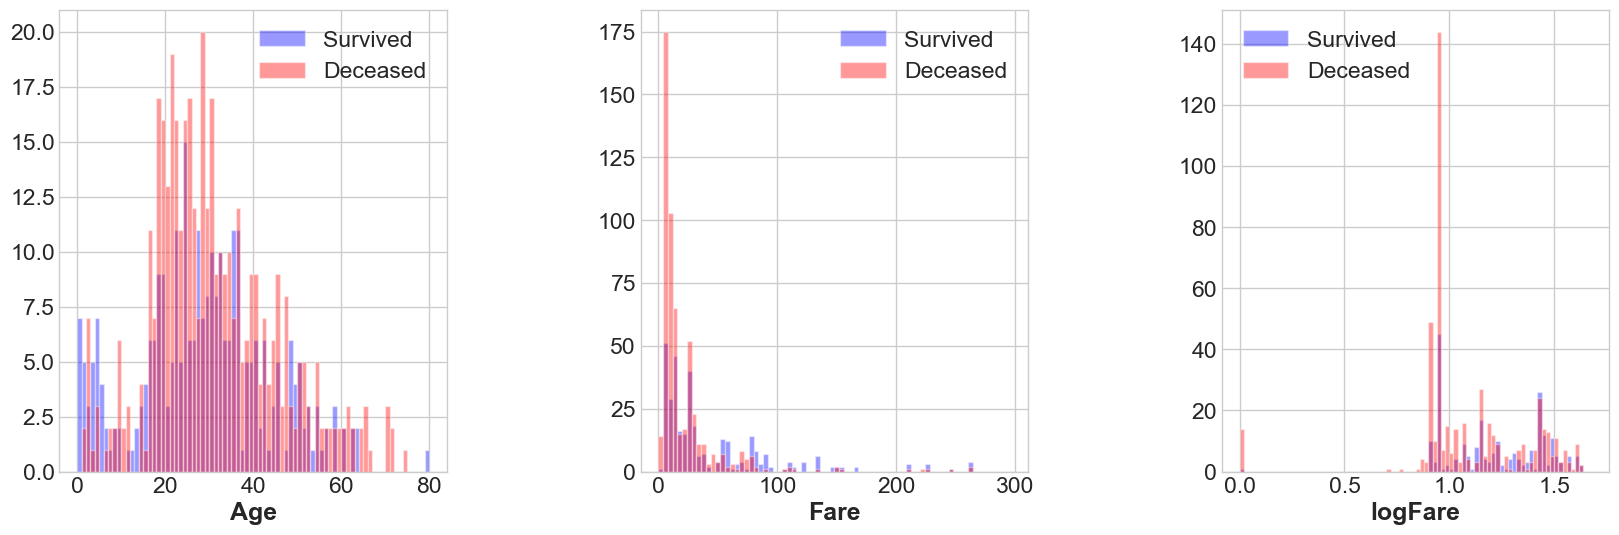

In [79]:
# survival rate on different features
# numerical variables
num_variables = ['Age', 'Fare', 'logFare']

# you are encouraged to play around with the bins and see the effect on plots
bins = [range(0, 81, 1), range(0, 300, 4), np.arange(0, 1.7, 0.02)]
def create_hists(data, variables, bins = bins, cols=3, width=20, height=6, hspace=0.5, wspace=0.5):
    sns.set(font_scale=1.5)
    plt.style.use('seaborn-whitegrid')
    fig = plt.figure(figsize=(width, height))
    fig.subplots_adjust(wspace=wspace, hspace=hspace)
    rows = math.ceil(len(variables) / cols)
    
    survived = data[data['Survived'] == 1]
    passed = data[data['Survived'] == 0]

    for i, column in enumerate(data[variables].columns):
        ax = fig.add_subplot(rows, cols, i + 1)
        sns.distplot(survived[column].dropna(), bins = bins[i], kde = False, color = 'blue')
        sns.distplot(passed[column].dropna(), bins = bins[i], kde = False, color = 'red')
        plt.xticks(rotation=0)
        plt.xlabel(column, weight='bold')
        plt.legend(['Survived', 'Deceased'])
        
create_hists(df, num_variables)

Summary: 
- **Age**: Children under the age of 15 yielded a significant higher chance to survive. 
- **Age**: People in their middle age are more likely to perish
- **Age**: Seems like people in their 50s have higher chance to survive, but those older are more likely to perished
- **Fare**: Lower fare gives lower survival rate, the effect of fare on survival rate is vague when it comes to a higher level of fare
- **Fare**: Nearly all of those who did not pay perished, this might be telling us that they should be excludes from the model

# Exploring Relationship between Variables

<AxesSubplot:>

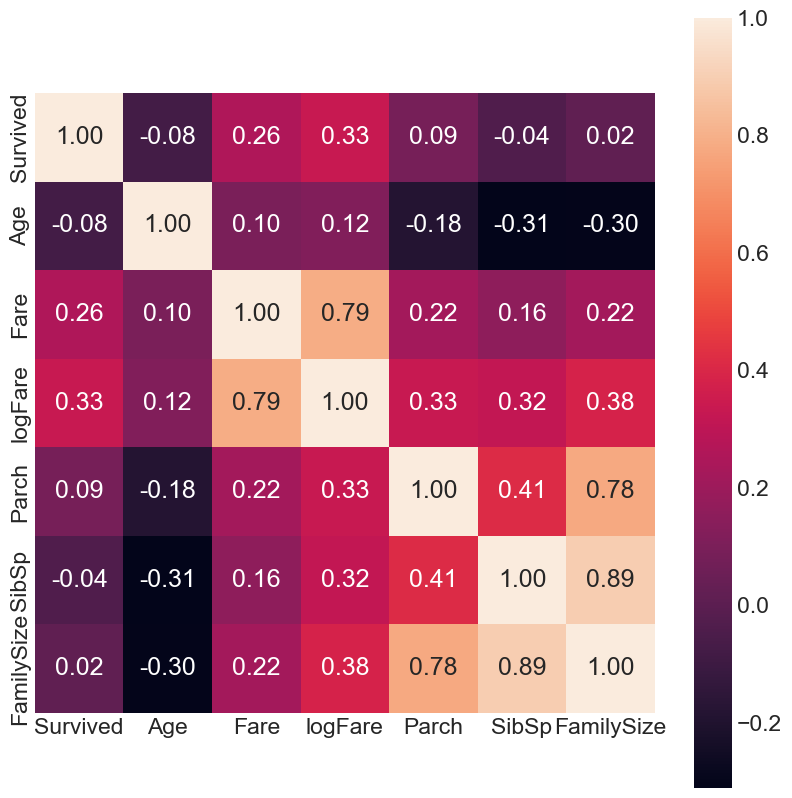

In [80]:
variables_list = ['Survived', 'Age', 'Fare', 'logFare', 'Parch', 'SibSp', 'FamilySize']

plt.figure(figsize=(10, 10))
sns.heatmap(df.iloc[:891,][variables_list].corr(), annot=True, fmt='.2f', square=True)

- **Fare** and **logFare** both have positive correlaiton with Survivied, but **logFare** is higher, which may imply that **logFare** is a better predictor than **Fare**
